In [1]:
import string
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import codecs
import joblib

import pymorphy3
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize

from annoy import AnnoyIndex

import warnings
warnings.filterwarnings('ignore')


---

In [2]:
# Функция предобработки текста, включающая в себя нормализацию, лемматезацию и токенизацию.
morpher = pymorphy3.MorphAnalyzer()

stop_words = set(stopwords.words('russian'))
sw = set(stop_words)

def preprocess_txt(line):
    if isinstance(line, str):
        exclude = set(string.punctuation)
        line = line.replace(',', ', ')
        line = line.replace('.', '. ')
        line = line.replace('не ', 'не')
        spls = "".join(i for i in line if i not in exclude).strip().split()
        spls = [morpher.parse(i.lower())[
            0].normal_form for i in spls if i.lower() not in sw and i != ""]
        
        spls = ' '.join(spls)
        
        return spls
    else:
        return str(line)


---

In [3]:
# Инициализация продуктового датасета
df = pd.read_csv("./data/ProductsDataset.csv")
df.rename(columns={'descrirption': 'description', 'product_id' : 'answer'}, inplace=True)
data_market = df[['title', 'description', 'answer']]

data_market['text'] = data_market['title'] + " " + data_market['description']
data_market.drop(['title', 'description'], axis=1, inplace=True)

data_market.dropna(inplace=True)

data_market.head()

,answer,text
0,58e3cfe6132ca50e053f5f82,"Юбка детская ORBY Новая, не носили ни разу. В ..."
1,5667531b2b7f8d127d838c34,"Ботильоны Новые,привезены из Чехии ,указан раз..."
2,59534826aaab284cba337e06,Брюки Размер 40-42. Брюки почти новые - не зна...
3,57de544096ad842e26de8027,"Продам детские шапки Продам шапки,кажда 200р.Р..."
4,5ad4d2626c86cb168d212022,"Блузка Темно-синяя, 42 размер,состояние отличн..."


In [4]:
# Предобработка продуктового датасета и присваивание номера класса для последующего
# обучения классификатора

data_market['text'] = data_market['text'].apply(preprocess_txt)
data_market['class'] = 1
data_market.head()

,answer,text,class
0,58e3cfe6132ca50e053f5f82,юбка детский orby новый неносить раз реал крас...,1
1,5667531b2b7f8d127d838c34,ботильон новый привезти чехия указать размер 4...,1
2,59534826aaab284cba337e06,брюки размер 4042 брюки новый незнать мерило п...,1
3,57de544096ad842e26de8027,продать детский шапка продать шапка кажда 200р...,1
4,5ad4d2626c86cb168d212022,блузка темносиний 42 размер состояние отличный...,1


---

In [5]:
# Инициализация датасета для фолбека
data_talker = pd.read_csv(
    './data/prepared_answers.txt', sep='\t',
    header=None, names=['text', 'answer'], 
    on_bad_lines="skip"
)

In [6]:
# Предобработка фолбек-датасета

data_talker.dropna(inplace=True)
data_talker['class'] = 0

data_talker = data_talker.iloc[:len(data_market)]

data_talker['text'] = data_talker['text'].apply(preprocess_txt)

data_talker.head()

,text,answer,class
1,парень относиться цветной линза девушка зелёны...,меня вобще прикалывает эта тема :).,0
2,делать сегодня найти 2 миллион рубль,"Если это ""счастье "" действительно на вас свали...",0
3,эбу двенашка называться итэлма эбу,ЭБУ — электронный блок управления двигателем а...,0
4,академия вампир сколько даный момент часть кни...,"4. Охотники и Жертвы, Ледяной укус, Поцелуй ть...",0
5,защититься энергетический вампир,Защита мыслью. <br>Каждый человек должен в отн...,0


---

## Этап моделирования классификатора продуктовый-фоллбэк запрос

### Склеим market_data и fallback_data

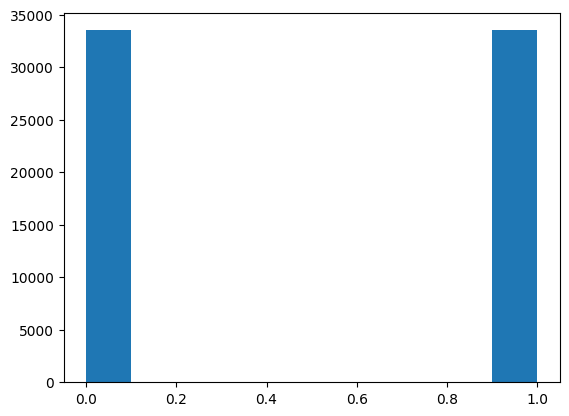

In [7]:
df = pd.concat([data_market, data_talker], axis=0)

# Проверим баланс классов
plt.hist(df['class'])
plt.show()

In [8]:
# Векторизируем и разобъем на трейн-тест (юыло принято решение ограничить размер вектора
# ибо в последующем файл индекса без ограничения занимал неприлично много места, 
# хоть точность и стала ниже)
X = df['text']
y = np.array(df['class'])

tfidf_vec = TfidfVectorizer(max_features=30000).fit(X)
X_tfidf = tfidf_vec.transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, train_size=0.8, random_state=42)


### Прогоним логистическую регрессию и случайный лес по-умолчанию и протестируем на бред

In [9]:
# Фитуем логрег
logreg = LogisticRegression(random_state=42, n_jobs=-1)
logreg.fit(X_train, y_train)

# Оцениваем
print("Accuracy:", logreg.score(X_test, y_test))

Accuracy: 0.9827791859251528


In [10]:
# Фитуем лес
random_forest = RandomForestClassifier(n_jobs=-1, random_state=42)
random_forest.fit(X_train, y_train)

# Оцениваем
print("Accuracy:", random_forest.score(X_test, y_test))

Accuracy: 0.981437304308931


### Проведем тест на рандомном инпуте.

In [11]:
input_test_1 = 'крокодилий шарф и сумка из кошачих хвостов на корабле со слонами'
input_test_2 = 'зеленые перчатки и шапка'
input_test_3 = 'юбка для собаки'
input_test_4 = 'коронарные выбросы плазмы в штанах'

In [12]:
new_data = tfidf_vec.transform(pd.Series(preprocess_txt(input_test_1)))
input_label_log = logreg.predict(new_data)
input_label_rf = random_forest.predict(new_data)

print("Logreg prediction of the class:",input_label_log)
print("Random forest prediction of the class:",input_label_rf)

Logreg prediction of the class: [1]
Random forest prediction of the class: [1]


In [13]:
new_data = tfidf_vec.transform(pd.Series(preprocess_txt(input_test_2)))
input_label_log = logreg.predict(new_data)
input_label_rf = random_forest.predict(new_data)

print("Logreg prediction of the class:",input_label_log)
print("Random forest prediction of the class:",input_label_rf)

Logreg prediction of the class: [1]
Random forest prediction of the class: [1]


In [14]:
new_data = tfidf_vec.transform(pd.Series(preprocess_txt(input_test_3)))
input_label_log = logreg.predict(new_data)
input_label_rf = random_forest.predict(new_data)

print("Logreg prediction of the class:",input_label_log)
print("Random forest prediction of the class:",input_label_rf)

Logreg prediction of the class: [1]
Random forest prediction of the class: [1]


In [15]:
new_data = tfidf_vec.transform(pd.Series(preprocess_txt(input_test_4)))
input_label_log = logreg.predict(new_data)
input_label_rf = random_forest.predict(new_data)

print("Logreg prediction of the class:",input_label_log)
print("Random forest prediction of the class:",input_label_rf)

Logreg prediction of the class: [0]
Random forest prediction of the class: [1]


### Вывод: При почти равном accuracy-score тест на бредовость текста показывает превосходство логистической регрессии.

---

### Сохраним модель, трансформер и создадим функцию для предобработки инпута

In [52]:
# Сохраним логрег
with open('./data/classification_model.pkl', 'wb') as output:
    pickle.dump(logreg, output)
    
# Сохраним объект векторизатор для дальнейшего использования
with open('./data/tfidf_transformer.pkl', 'wb') as output:
    pickle.dump(tfidf_vec, output)

In [16]:
def text_classification(line):
    
    with open('./data/tfidf_transformer.pkl', 'rb') as f:
        tfidf_vec = pickle.load(f)
        
    with open('./data/classification_model.pkl', 'rb') as f:
        logreg = pickle.load(f)
    
    def preprocess_txt(line):
        morpher = pymorphy3.MorphAnalyzer()
        stop_words = set(stopwords.words('russian'))
        sw = set(stop_words)
        
        if isinstance(line, str):
            exclude = set(string.punctuation)
            line = line.replace(',', ', ')
            line = line.replace('.', '. ')
            line = line.replace('не ', 'не')
            spls = "".join(i for i in line if i not in exclude).strip().split()
            spls = [morpher.parse(i.lower())[
                0].normal_form for i in spls if i.lower() not in sw and i != ""]
            
            spls = ' '.join(spls)
            
            return spls
        else:
            return str(line)
        
    text = preprocess_txt(line)
    text_vector = tfidf_vec.transform(pd.Series(text))
    
    label = logreg.predict(text_vector)
    
    return label[0], text_vector

In [17]:
print(text_classification(input_test_1))
print(text_classification(input_test_2))
print(text_classification(input_test_3))
print(text_classification(input_test_4))

(1, <1x30000 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>)
(1, <1x30000 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>)
(1, <1x30000 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>)
(0, <1x30000 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>)


---

In [18]:
# Векторизируем тексты в датафреймах целевого запроса и фоллбэка, предварительно
# дропнув фит метки класса, т.к. он нам больше не понадобится.
market = data_market['text']
market_vector = tfidf_vec.transform(market)

fallback = data_talker['text']
fallback_vector = tfidf_vec.transform(fallback)

### Следующие блоки закоментированы для избежания перезаписи 

In [56]:
'''# Конструируем индекс для продуктового запроса
index = AnnoyIndex(market_vector.shape[1], 'angular')  # косинусное расстояние

# Добавляем индекс
for i, v in enumerate(market_vector):
    index.add_item(i, v.toarray()[0])

# Конструируем
num_trees = 10
index.build(num_trees, n_jobs=-1)

# Сохраняем
index.save('./data/market_index.ann')'''

True

In [57]:
'''# Конструируем индекс для фоллбека запроса
index = AnnoyIndex(fallback_vector.shape[1], 'angular')  # косинусное расстояние

# Добавляем индекс
for i, v in enumerate(fallback_vector):
    index.add_item(i, v.toarray()[0])

# Конструируем
num_trees = 10
index.build(num_trees)

# Сохраняем
index.save('./data/fallback_index.ann')'''

True

----

In [19]:
# Загружаем файлы индекса
index_market = AnnoyIndex(30000, 'angular') 
index_market.load('./data/market_index.ann')

index_fallback = AnnoyIndex(30000, 'angular') 
index_fallback.load('./data/fallback_index.ann')


True

In [20]:
# Проверим новые данные
new_data = 'Юбка детская ORBY'

label, text = text_classification(new_data)
print("Class of object:", label)

Class of object: 1


In [21]:
# Найдем ближайшего соседа на примере продуктового запроса
num_neighbors = 1
nearest_index = index_market.get_nns_by_vector(text.toarray()[0], num_neighbors)

# Находим ответ на основе индекса
nearest_answer = df.iloc[nearest_index[0]]['answer']
print(nearest_answer)

58e3cfe6132ca50e053f5f82


---

### Реинициализируем датасеты и сохраним их в новом виде

In [22]:
df_market = pd.read_csv("./data/ProductsDataset.csv")
df_market.rename(columns={'descrirption': 'description', 'product_id' : 'answer'}, inplace=True)
df_market = df_market[['title', 'description', 'answer']]
df_market.to_csv('./data/market_answer.csv', index=0)

In [23]:
# Инициализация датасета для фолбека
df_fallback = pd.read_csv(
    './data/prepared_answers.txt', sep='\t',
    header=None, names=['text', 'answer'], 
    on_bad_lines="skip"
)
df_fallback.dropna(inplace=True)
df_fallback = df_fallback.iloc[:len(df_market)]
df_fallback.to_csv('./data/fallback_answer.csv', index=0)

In [24]:
# Найдем ближайшего соседа с использованием логики
if label == 1:
    num_neighbors = 1
    nearest_index = index_market.get_nns_by_vector(text.toarray()[0], num_neighbors)

    # Находим ответ на основе индекса
    nearest_answer = df_market.iloc[nearest_index[0]]['answer']
    print(nearest_answer)
else:
    num_neighbors = 1
    nearest_index = index_fallback.get_nns_by_vector(text.toarray()[0], num_neighbors)

    # Находим ответ на основе индекса
    nearest_answer = df_fallback.iloc[nearest_index[0]]['answer']
    print(nearest_answer)

58e3cfe6132ca50e053f5f82


---

### Финальный этап - функция get_answer() и автотесты

In [25]:
# Напишем функцию для выдачи ответа на основе логики классификации (1-продуктовый запрос, 0-болталка)
def get_answer(text):
    # Инициализируем датасеты
    market_answer = pd.read_csv('./data/market_answer.csv')
    fallback_answer = pd.read_csv('./data/fallback_answer.csv')

    # Загружаем файлы индекса
    index_market = AnnoyIndex(30000, 'angular') 
    index_market.load('./data/market_index.ann')

    index_fallback = AnnoyIndex(30000, 'angular') 
    index_fallback.load('./data/fallback_index.ann')

    # Функция классификатора с подгрузкой моделей и предобработкой
    def text_classification(line):
    
        with open('./data/tfidf_transformer.pkl', 'rb') as f:
            tfidf_vec = pickle.load(f)
            
        with open('./data/classification_model.pkl', 'rb') as f:
            logreg = pickle.load(f)
        
        def preprocess_txt(line):
            morpher = pymorphy3.MorphAnalyzer()
            stop_words = set(stopwords.words('russian'))
            sw = set(stop_words)
            
            if isinstance(line, str):
                exclude = set(string.punctuation)
                line = line.replace(',', ', ')
                line = line.replace('.', '. ')
                line = line.replace('не ', 'не')
                spls = "".join(i for i in line if i not in exclude).strip().split()
                spls = [morpher.parse(i.lower())[
                    0].normal_form for i in spls if i.lower() not in sw and i != ""]
                
                spls = ' '.join(spls)
                
                return spls
            else:
                return str(line)
            
        line = preprocess_txt(text)
        text_vector = tfidf_vec.transform(pd.Series(line))
        
        label = logreg.predict(text_vector)
        # Вернем метку и векторизированный текст
        return label[0], text_vector
    
    label, text_vector = text_classification(text)
    
    # Если метка равна 1, т.е. продуктовый запрос, начинаем искать по индксу продукта
    if label == 1:
        num_neighbors = 1
        nearest_index = index_market.get_nns_by_vector(text_vector.toarray()[0], num_neighbors)

        # Находим ответ на основе индекса
        nearest_answer = market_answer.iloc[nearest_index[0]]['answer']
        return nearest_answer
    
    # Иначе ищем по болталке
    else:
        num_neighbors = 1
        nearest_index = index_fallback.get_nns_by_vector(text_vector.toarray()[0], num_neighbors)

        # Находим ответ на основе индекса
        nearest_answer = fallback_answer.iloc[nearest_index[0]]['answer']
        return nearest_answer

    

In [26]:
assert get_answer('Юбка детская ORBY').startswith('58e3cfe6132ca50e053f5f82')
assert not get_answer('Где ключи от танка').startswith('5')

> Вывод: Автотесты пройдены